## Import

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from typing import List, Union
from joblib import Parallel, delayed

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU ', torch.cuda.current_device())
else:
    device = torch.device('cpu')
    print('using CPU')


/home/inglab/miniconda3/envs/dasegment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/inglab/miniconda3/envs/dasegment/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


using GPU  0


## Utils

In [2]:
# RLE 디코딩 함수
def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''
    
    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    prediction_df.index = range(prediction_df.shape[0])

    # Extract the mask_rle columns
    pred_mask_rle = prediction_df.iloc[:, 1]
    gt_mask_rle = ground_truth_df.iloc[:, 1]


    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)

        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None

    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )

    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

## Custom Dataset

In [3]:
train_transform = A.Compose([
                    A.Resize(224, 224),
                    A.Normalize(),
                    ToTensorV2(transpose_mask=True)
                ])

train_mask_transform = A.Compose([
                    A.Resize(224, 224),
                    ToTensorV2(transpose_mask=True)
                ])

test_transform = A.Compose([
                    A.Resize(224, 224),
                    A.Normalize(),
                    ToTensorV2(transpose_mask=True)
                ])

class SatelliteDatasetTraining(Dataset):
    def __init__(self, input_path='./input224', transform=train_transform, mask_transform=train_mask_transform):
        mask_path = input_path.replace('input', 'mask')
        self.input_data = [input_path + '/' + input_filename for input_filename in os.listdir(input_path)]
        self.mask_data = [mask_path + '/' + mask_filename for mask_filename in os.listdir(mask_path)]
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        image = cv2.imread(self.input_data[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_data[idx], cv2.IMREAD_GRAYSCALE)

        augmented_image = self.transform(image = image)
        augmented_mask = self.mask_transform(image = mask)
        image = augmented_image['image']
        mask = augmented_mask['image']
        
        mask[mask != 0] = 1
        
        return image, mask

class SatelliteDatasetInfer(Dataset):
    def __init__(self, csv_file, transform = None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = self.transform(image=image)['image']
        
        return image

## Data Loader

In [4]:
dataset = SatelliteDatasetTraining(transform=train_transform, mask_transform=train_mask_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


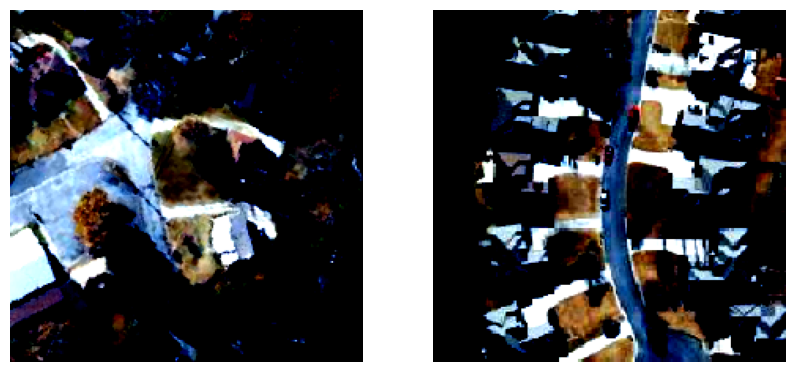

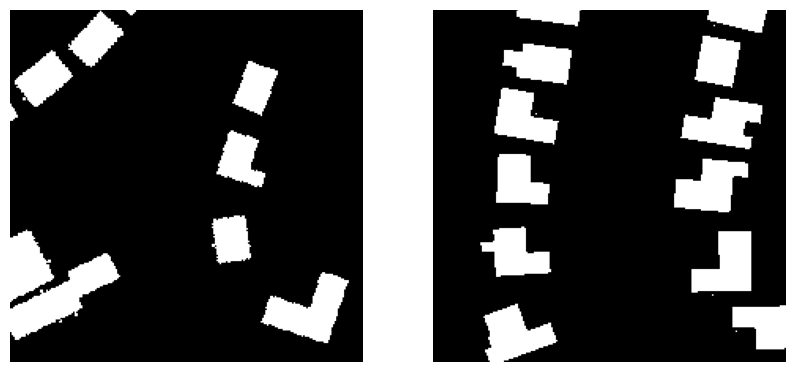

In [5]:
# visualization
import matplotlib.pyplot as plt

dataset_to_check = dataset

sample_indices = np.random.choice(len(dataset_to_check), size=2, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, ax in enumerate(axes):
    index = sample_indices[i]
    sample = dataset_to_check[index]

    image = np.transpose(sample[0], (1, 2, 0))
    
    ax.imshow(image)
    ax.axis('off')

plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, ax in enumerate(axes):
    index = sample_indices[i]
    sample = dataset[index]

    mask = sample[1].numpy()
    mask = np.squeeze(mask)

    ax.imshow(mask, cmap='gray')
    ax.axis('off')

plt.show()

## Define Model

In [6]:
import torchvision

resnet = torchvision.models.resnet.resnet50(pretrained=True)

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=1):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

/home/inglab/miniconda3/envs/dasegment/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/inglab/miniconda3/envs/dasegment/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model Train

In [7]:

class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-7):

        inputs = torch.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.0*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-7):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.0*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, inputs, targets):
        # inputs and targets are assumed to be BatchxClasses

        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        # compute the negative likelyhood
        logpt = - torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets)
        pt = torch.exp(logpt)

        # compute the loss
        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss


In [8]:
# Use K-fold for cross validation
from sklearn.model_selection import KFold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
best_model_per_fold_list = [''] * k_folds
best_model_score = [0] * k_folds
dataset_list = list(range(len(dataset)))

# 하이퍼파라미터
epoch_num = 100
learning_rate = 0.0001
patience = 5

best_dice_score = 0
counter = 0

for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset_list)):
    print(f"Fold {fold + 1} / {k_folds}")
    
    dataset = SatelliteDatasetTraining(transform=train_transform)
    
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
    val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

    # model 초기화
    model = UNetWithResnet50Encoder().to(device)
    model = nn.DataParallel(model, device_ids=[0, 1])

    # loss function과 optimizer 정의
    criterion = DiceLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.002, steps_per_epoch=len(train_dataloader), epochs=epoch_num)
    
    # training loop
    for epoch in range(epoch_num):
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(train_dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
        epoch_loss /= len(train_dataloader)
            
        # validation
        epoch_val_loss = 0
        dice_scores_list = []

        with torch.no_grad():
            model.eval()
            for images, masks in tqdm(val_dataloader):
                images = images.float().to(device)
                masks = masks.float().to(device)
                
                outputs = model(images)
                val_loss = criterion(outputs, masks.unsqueeze(1))
                epoch_val_loss += val_loss.item()
                
                masks = masks.cpu().numpy()

                pred_masks = torch.sigmoid(outputs).cpu().numpy()
                pred_masks = np.squeeze(pred_masks, axis=1)
                pred_masks = (pred_masks > 0.35).astype(np.uint8) # Threshold = 0.35

                pred_df = pd.DataFrame(columns=["img_id", "rle_mask"])
                gt_df = pd.DataFrame(columns=["img_id", "rle_mask"])

                for img_id, (pred_mask, mask) in enumerate(zip(pred_masks, masks)):
                    pred_rle = rle_encode(pred_mask)
                    gt_rle = rle_encode(mask)
                    pred_df.loc[img_id] = [img_id, pred_rle]
                    gt_df.loc[img_id] = [img_id, gt_rle]
                    
                dice_score_batch = calculate_dice_scores(gt_df, pred_df)
                dice_scores_list.append(dice_score_batch)

        avg_dice_score = np.mean(dice_scores_list)
        epoch_val_loss /= len(val_dataloader)

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss}, Val Loss: {epoch_val_loss}, Val Dice Score: {avg_dice_score}')
        #print(f'Learning Rate for Epoch {epoch+1}: {optimizer.param_groups[0]["lr"]}')
        #scheduler.step()
        
        if avg_dice_score > best_dice_score:
            best_dice_score = avg_dice_score
            counter = 0
            best_model_name = f'best_model_fold{fold+1}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), best_model_name)
            best_model_per_fold_list[fold] = best_model_name
            best_model_score[fold] = avg_dice_score
        else:
            counter += 1
            if counter >= patience:
                print('Early Stopping')
                break

Fold 1 / 5


100%|██████████| 274/274 [05:26<00:00,  1.19s/it]


Epoch 1, Train Loss: 0.3216106422843724, Val Loss: 0.2608339197009149, Val Dice Score: 0.6094356300997347


100%|██████████| 274/274 [05:19<00:00,  1.17s/it]


Epoch 2, Train Loss: 0.24259130662157588, Val Loss: 0.24728614526943568, Val Dice Score: 0.6360132242580923


100%|██████████| 274/274 [05:17<00:00,  1.16s/it]


Epoch 3, Train Loss: 0.23029288127474543, Val Loss: 0.2408144802507693, Val Dice Score: 0.6332996884474549


 69%|██████▊   | 188/274 [03:44<01:42,  1.20s/it]


KeyboardInterrupt: 

## Inference

In [7]:
test_dataset = SatelliteDatasetInfer(csv_file='./test.csv', transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

In [8]:
model = UNetWithResnet50Encoder().to(device)
model = nn.DataParallel(model, device_ids=[0, 1])

# load best model
best_fold = best_model_score.index(max(best_model_score))
model.load_state_dict(torch.load(best_model_per_fold_list[best_fold]))

with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        
        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

/home/inglab/miniconda3/envs/dasegment/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/inglab/miniconda3/envs/dasegment/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 474/474 [04:12<00:00,  1.88it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


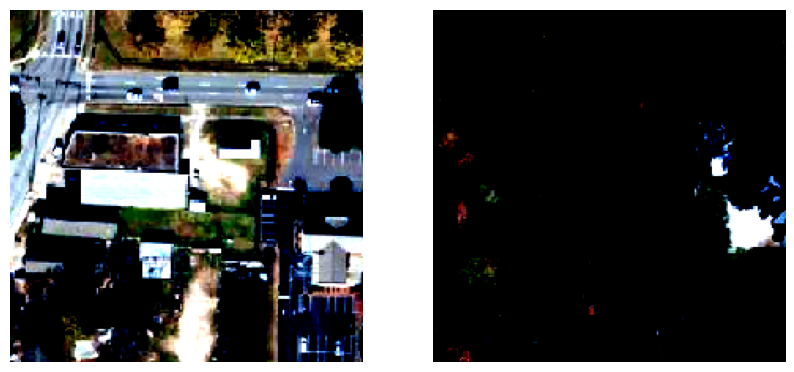

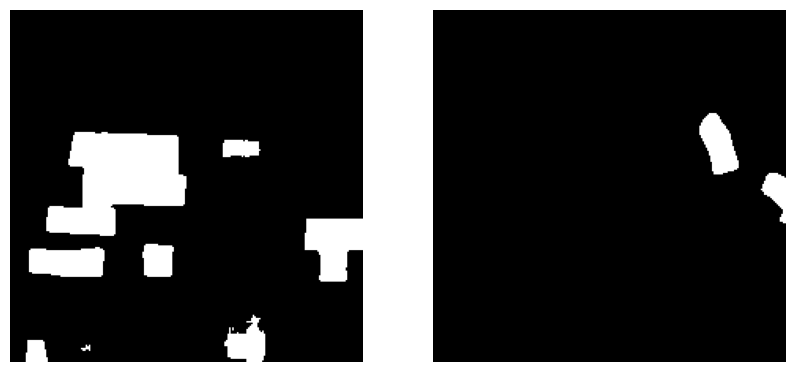

In [17]:
# visualization
import matplotlib.pyplot as plt

sample_indices = np.random.choice(len(test_dataset), size=2, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, ax in enumerate(axes):
    index = sample_indices[i]
    sample = test_dataset[index]

    image = np.transpose(sample, (1, 2, 0))
    
    ax.imshow(image)
    ax.axis('off')

plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, ax in enumerate(axes):
    index = sample_indices[i]
    sample = rle_decode(result[index])

    mask = np.squeeze(sample)

    ax.imshow(mask, cmap='gray')
    ax.axis('off')

plt.show()

## Submission

In [18]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [19]:
submit_name = 'resnet_unet_224data_submit.csv'
submit.to_csv(submit_name, index=False)

In [20]:
submit_df = pd.read_csv(submit_name)
print('test size: ', len(submit_df['mask_rle']))
cnt = 0
for mask_rle in submit_df['mask_rle']:
    if mask_rle == '-1':
        cnt += 1
print('pred -1: ', cnt)

test size:  60640
pred -1:  15571
